# Chronos Time-Series Tutorial: Pretrained (Language) Models for Probabilistic Time Series Forecasting

Name: John Hodge

Date: 06/06/2024

Source: [Chronos: Learning the Language of Time Series](https://github.com/amazon-science/chronos-forecasting)

## Introduction

In this tutorial, we'll explore Chronos, a novel approach to time series forecasting that treats time series data as a language and leverages powerful language model architectures like Transformers. Developed by researchers at Google AI, Chronos achieves impressive performance on a wide range of time series forecasting tasks without requiring extensive dataset-specific tuning or model customization.

The key insight behind Chronos is to tokenize real-valued time series observations into a fixed vocabulary, enabling us to apply off-the-shelf language models to the "language of time series." This is achieved by scaling the time series by its absolute mean and then quantizing the scaled values into uniformly spaced bins, which are assigned unique tokens. Special tokens like PAD and EOS are also added to handle padding and end-of-sequence.

Once tokenized, the time series data can be fed into standard language models like T5, which are trained using the conventional cross-entropy loss function, with no changes to the model architecture itself. Despite its simplicity, Chronos demonstrates remarkable accuracy, outperforming classical statistical methods and specialized deep learning models on held-out data, and achieving comparable or superior zero-shot performance on entirely new datasets.

#### High-level depiction of Chronos

![Chronos](https://github.com/amazon-science/chronos-forecasting/raw/main/figures/main-figure.png)

*Fig. 1: High-level depiction of Chronos. (Left) The input time series is scaled and quantized to obtain a sequence of tokens. (Center) The tokens are fed into a language model which may either be an encoder-decoder or a decoder-only model. The model is trained using the cross-entropy loss. (Right) During inference, we autoregressively sample tokens from the model and map them back to numerical values. Multiple trajectories are sampled to obtain a predictive distribution* [[Source](https://github.com/amazon-science/chronos-forecasting)].

## Tutorial

In this tutorial, we'll walk through the following steps:

1. **Data Preparation**: Loading and preprocessing time series data for use with Chronos.
2. **Tokenization**: Implementing the time series tokenization process described above.
3. **Model Training**: Training a language model on the tokenized time series data.
4. **Evaluation**: Assessing the performance of the trained model on held-out data.
5. **Inference**: Using the trained model for time series forecasting on new data.

By the end of this tutorial, you'll have a solid understanding of how Chronos works and how to apply it to your own time series forecasting tasks. Let's get started!

In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-4nuphwyw
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-4nuphwyw
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 601d52db75455e6b0a3bbf16f4c3c26370fefd51
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl 

In [ ]:
# Print compute instance type
!nvidia-smi -L

GPU 0: NVIDIA L4 (UUID: GPU-8ece455b-8358-07c3-046b-59e60ee1bb29)


In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from chronos import ChronosPipeline

In [ ]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

In [ ]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=12,
    num_samples=20,
)

In [ ]:
forecast_index = range(len(df), len(df) + 12)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

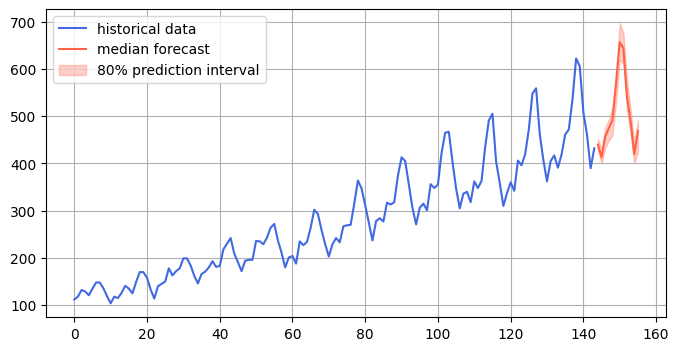

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

## References

- [Chronos: Learning the Language of Time Series](https://github.com/amazon-science/chronos-forecasting)
- [Adapting language model architectures for time series forecasting](https://www.amazon.science/blog/adapting-language-model-architectures-for-time-series-forecasting)

## Appendix

### A1) Summary of "Chronos: Learning the Language of Time Series"

#### Abstract

**Chronos Framework:**  
- **Objective:** Introduces a simple yet effective framework for pretrained probabilistic time series models.
- **Method:** Chronos tokenizes time series values using scaling and quantization into a fixed vocabulary. It trains existing transformer-based language model architectures on these tokenized time series via cross-entropy loss.
- **Models:** Pretrained Chronos models based on the T5 family (ranging from 20M to 710M parameters) on a large collection of publicly available datasets, supplemented by synthetic data generated via Gaussian processes.
- **Results:** Chronos models outperform other methods on datasets that were part of the training corpus and show comparable or superior zero-shot performance on new datasets relative to methods trained specifically on them.
- **Implication:** Demonstrates that pretrained models can leverage diverse time series data to improve zero-shot accuracy on unseen forecasting tasks, simplifying forecasting pipelines.

#### Introduction

**Importance of Time Series Forecasting:**  
- Essential for decision-making in various domains like retail, energy, finance, healthcare, and climate science.
- Traditional methods include ARIMA and ETS.
- Deep learning techniques have emerged due to the availability of large and diverse data sources and operational forecasting problems.

**Shift Towards Pretrained Models:**  
- Interest in developing foundation models for time series due to the success of large language models (LLMs) with zero-shot learning capabilities.
- Existing methods either directly prompt pretrained LLMs in natural language or fine-tune LLMs for time series tasks.

**Chronos Approach:**  
- Treats time series as a sequence and tokenizes the values into discrete bins through scaling and quantization.
- Trains off-the-shelf language models on these tokenized time series without changes to the model architecture.

#### Chronos Framework

**Tokenization:**  
- Maps time series values to a finite set of tokens using scaling and quantization.
- Uses mean scaling to normalize time series values.
- Employs uniform binning for quantization to ensure generalization across different datasets.

**Training:**  
- Trains language models using the cross-entropy loss.
- Models learn to predict the next value in the series by modeling the sequential structure of the data.
- Does not incorporate time and frequency information, treating time series as sequences.

**Forecasting:**  
- Probabilistic forecasting is achieved by autoregressively sampling from the predicted distribution.
- Dequantization and unscaled mapping are applied to obtain actual forecasts.

#### Data Augmentation

**Synthetic Data Generation:**  
- Enhances training data diversity through TSMixup and KernelSynth techniques.
- TSMixup generates new time series by combining base series from different training datasets.
- KernelSynth uses Gaussian processes to generate synthetic time series.

#### Evaluation

**Comprehensive Benchmark:**  
- Evaluated across 42 datasets, showing superior performance on in-domain and zero-shot forecasting.
- Outperforms both traditional models and task-specific deep learning approaches.

#### Conclusion

**Chronos as a Benchmark:**  
- Establishes a strong benchmark for both in-domain and zero-shot forecasting.
- Its accuracy and modest model size make it a preferable alternative to larger, more computationally demanding models.

**Future Directions:**  
- Suggests potential for Chronos to be further developed as a generalist time series model, leveraging advancements in LLMs.

### Key Contributions

1. Introduces a minimalistic yet effective framework for probabilistic time series forecasting using language models.
2. Demonstrates that pretrained language models can achieve high zero-shot forecasting accuracy.
3. Proposes data augmentation techniques to enhance model robustness and generalization.

Chronos bridges the gap between language models and time series forecasting, showing that language model architectures can be effectively applied to time series problems with minimal modifications.

Link to paper: https://arxiv.org/pdf/2403.07815

### A2) Chronos Pipelines

In [ ]:
print(ChronosPipeline.predict.__doc__)


        Get forecasts for the given time series.

        Parameters
        ----------
        context
            Input series. This is either a 1D tensor, or a list
            of 1D tensors, or a 2D tensor whose first dimension
            is batch. In the latter case, use left-padding with
            ``torch.nan`` to align series of different lengths.
        prediction_length
            Time steps to predict. Defaults to what specified
            in ``self.model.config``.
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            